# **Import Modules**

In [1]:
import sys

import os

import random as pyrand

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sys.path.insert(0, '../input/deeplearning-utils')

In [2]:
from utils.ops import plot

from utils.tf.ops import io, eval as tf_eval

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

from tqdm import tqdm

In [4]:
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

In [5]:
import tensorflow as tf

from tensorflow.keras import backend, optimizers, regularizers

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential, Model

# from tensorflow.keras.applications import *

from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_addons as tfa

# **Config**

In [6]:
def set_seed(tf_seed=0, np_seed=0, py_rand=0, py_hash=0):

    os.environ['PYTHONHASHSEED'] = str(py_hash)
    pyrand.seed(py_rand)

    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)

In [7]:
PATH = {'224': 'cisc22placesandscene224x224'}

In [8]:
class Config:
    
    SEED = 2053
    
    IMAGE_SIZE = (224, 224)

    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 32
        
    SPLIT =10
        
    EPOCHS = 100
    
    TRAINING = True

In [9]:
set_seed(Config.SEED)

In [10]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
    
except ValueError:
  
    tpu = None

if tpu is not None:
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    
    strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [11]:
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

GCS_DS_PATH = KaggleDatasets().get_gcs_path(PATH['224'])

In [12]:
augmentations = []

augmentations.append(preprocessing.RandomFlip(mode='horizontal'))
augmentations.append(preprocessing.RandomContrast(factor=0.8))
augmentations.append(preprocessing.RandomRotation(factor=0.1, dtype=tf.float32))

augmentations = Sequential(augmentations)

# **Load Data**

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [14]:
train_rec = tf.io.gfile.glob(GCS_DS_PATH + '/train/train/*')

train_rec = np.array(train_rec)

print(len(train_rec))

50


In [15]:
@tf.function
def add_perturbation(y, ratio=0.25):
    
    batch_size = tf.shape(y)[0]
    num_classes = tf.shape(y)[1]
    
    if batch_size < 4:
        
        return y
    
    y = tf.math.argmax(y, axis=-1)
    
    size = tf.cast(batch_size, dtype=tf.float32)
    size = tf.cast(tf.math.ceil(ratio * size), dtype=tf.int32)
    
    indices = tf.random.uniform(shape=(size, 1), minval=0, maxval=batch_size, dtype=tf.int32)
    values = tf.random.uniform(shape=(size, ), minval=0, maxval=6, dtype=tf.int32)
    
    y = tf.cast(y, dtype=tf.int32)
    
    y = tf.tensor_scatter_nd_update(y, indices, values)
    
    return tf.one_hot(y, depth=num_classes)

In [16]:
def train_processing(x, y):
        
    x = tf.cast(x, dtype=tf.float32)
#     x /= 255.0
        
    y = tf.one_hot(y, depth=6)
    
    return augmentations(x, training=Config.TRAINING), y

In [17]:
def split_generator(train_idx, val_idx):
    
    dtype = {'image': 'bytes', 'label': 'int64'}
    
    reader = io.TfRecordReader(features_dtype=dtype,  image_key='image', 
                               tfrecord_shape=[*Config.IMAGE_SIZE, 3],  
                               shape=None, channels=3,  func=None)
    
    train_data = tf.data.TFRecordDataset(train_rec[train_idx], num_parallel_reads=AUTOTUNE)
    train_data = train_data.with_options(ignore_order)

    train_data = train_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    train_data = train_data.shuffle(512, reshuffle_each_iteration=True)
    train_data = train_data.batch(Config.TRAIN_BATCH_SIZE)
    train_data = train_data.prefetch(AUTOTUNE)
    train_data = train_data.map(train_processing)
    
    val_data = tf.data.TFRecordDataset(train_rec[val_idx], num_parallel_reads=AUTOTUNE)
    val_data = val_data.with_options(ignore_order)

    val_data = val_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    val_data = val_data.batch(Config.VAL_BATCH_SIZE)
    val_data = val_data.prefetch(AUTOTUNE)
    val_data = val_data.map(train_processing)
    
    return train_data, val_data

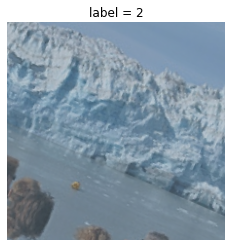

In [18]:
sample_x, sample_y = split_generator(0, 1)[0].unbatch().as_numpy_iterator().next()

plt.imshow(sample_x / 255.0)
plt.title(f'label = {int(sample_y.argmax())}')
plt.axis('off')
plt.show()

# **Build Model**

In [19]:
input_shape = (*Config.IMAGE_SIZE, 3)

In [20]:
with strategy.scope():
    
    efficientnet = tf.keras.models.load_model('../input/cisc22buildefficientnetbn/efficientnetb7.h5', compile=False)
    
    efficientnet.load_weights('../input/cisc22buildefficientnetbn/noisy_student_efficientnet-b7.h5')
    
    outputs = []
    
    outputs.append(efficientnet.get_layer('block2g_add').output)
    outputs.append(efficientnet.get_layer('block3g_add').output)
    
    backbone = Model(efficientnet.inputs, outputs)

In [21]:
class ARD(Model):
    
    def __init__(self, *args, **kwargs):
        
        super(ARD, self).__init__(*args, **kwargs)
        
        self.compile_discriminator()
        
    def compile_discriminator(self):
        
        inputs = Input(shape=(6, ))
        
        z = Dense(1000)(inputs)
        z = Activation('swish')(z)
        z = GaussianDropout(0.1)(z)
        
        z = Dense(1000)(z)
        z = Activation('swish')(z)
        
        l1_l2 = regularizers.l1_l2(l1=0.5)
        
        outputs = Dense(1, kernel_regularizer=l1_l2)(z)
        
        outputs = Activation('sigmoid')(outputs)
        
        self.discriminator = Model(inputs, outputs, name='discriminator')
        
    def train_step(self, data):

        x, y = data
        
        y_perturbed = add_perturbation(y)

        with tf.GradientTape() as tape:

            y_pred = self(x, training=True)
            
            true_sample = self.discriminator(y_perturbed)
            fake_sample = self.discriminator(y_pred)
            
            ard_loss = backend.binary_crossentropy(true_sample, fake_sample)
            ard_loss = backend.mean(ard_loss)
            
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            loss += 2.0 * ard_loss
        
        # -------------------------------------------------------

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # -------------------------------------------------------
        # update
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # -------------------------------------------------------

        self.compiled_metrics.update_state(y, y_pred)

        # -------------------------------------------------------
        
        ret = {'ard_loss': ard_loss}
        
        ret.update({m.name: m.result() for m in self.metrics})
        
        return ret

In [22]:
def build_model():
    
    backbone.trainable = False
    
    # ===================================================================================
    
    inputs = Input(shape=input_shape)
    
    block2g, block3g = backbone(inputs)
    
    z0 = Conv2D(filters=1024, kernel_size=(1, 1), activation='linear', kernel_regularizer=None)(block2g)
    z0 = GlobalAveragePooling2D()(z0)

    z1 = Conv2D(filters=1024, kernel_size=(1, 1), activation='swish', kernel_regularizer=None)(block3g)
    z1 = Dropout(0.2)(z1)    
    z1 = GlobalAveragePooling2D()(z1)
    
    z = Concatenate(axis=-1)([z0, z1])
    
    # ===================================================================================

    y_logits = Dense(6, name='y_logits')(z)
    y_proba = Activation('softmax', name='y_proba')(y_logits)
    
    # ===================================================================================

    model = ARD(inputs, y_proba)
    
    # ===================================================================================
    
    optimizer = optimizers.Adam(learning_rate=5e-7, beta_1=0.9, beta_2=0.999)
    
    loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.01, name='categorical_crossentropy')
    metrics = tf.metrics.CategoricalAccuracy(name='accuracy_score')
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # ===================================================================================

    return model

In [23]:
build_model().summary()

Model: "ard"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 28, 28, 48), 1005128     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 1024)   82944       model[0][1]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 1024) 50176       model[0][0]                      
________________________________________________________________________________________________

# **Train Model**

In [24]:
weights_path = tf.io.gfile.glob('../input/cisc22placesandscenepretrainedtrainv0/weights-*.h5')

print(len(weights_path))

1


In [25]:
kfold = KFold(n_splits=Config.SPLIT, shuffle=False)

for i, (train_idx, val_idx) in enumerate(kfold.split(train_rec)):
    
    train_data, val_data = split_generator(train_idx, val_idx)
    
    print(f'fold {i} - {"=" * 100}')
    
    with strategy.scope():
        
        model = build_model()
    
    if i < len(weights_path):
        
        model.load_weights(weights_path[i])
        
    model.fit(train_data, epochs=Config.EPOCHS, validation_data=val_data, callbacks=None)
    
    model.save_weights(f'weights-{i}.h5')
    
    backend.clear_session()

    # stop cv
    if i == 0:
        
        break

fold 0 - ====================================================================================================
Epoch 1/100
384/384 [==============================] - 127s 297ms/step - ard_loss: 0.0023 - loss: 0.6288 - accuracy_score: 0.8166 - val_loss: 0.6155 - val_accuracy_score: 0.8205
Epoch 2/100
384/384 [==============================] - 113s 291ms/step - ard_loss: 0.0023 - loss: 0.6320 - accuracy_score: 0.8130 - val_loss: 0.6142 - val_accuracy_score: 0.8278
Epoch 3/100
384/384 [==============================] - 112s 291ms/step - ard_loss: 0.0023 - loss: 0.6204 - accuracy_score: 0.8122 - val_loss: 0.6089 - val_accuracy_score: 0.8205
Epoch 4/100
384/384 [==============================] - 113s 293ms/step - ard_loss: 0.0023 - loss: 0.6197 - accuracy_score: 0.8143 - val_loss: 0.6061 - val_accuracy_score: 0.8220
Epoch 5/100
384/384 [==============================] - 113s 292ms/step - ard_loss: 0.0023 - loss: 0.6319 - accuracy_score: 0.8078 - val_loss: 0.6035 - val_accuracy_score: 0.8168
